In [1]:
%reset -f
import gc
gc.collect()

from math import *
import numpy as np

import matplotlib.pyplot as plt

import time

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Conv1DTranspose, MaxPooling1D, Flatten, Reshape, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Nadam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow import GradientTape
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import Mean, BinaryAccuracy
from tensorflow.math import reduce_mean
from tensorflow import clip_by_value


from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

2023-09-11 14:10:30.546481: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 14:10:30.569427: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 14:10:30.569937: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 14:10:31.059775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Useful parameters
hit_len = 11

# Random seeds initialization
tf.random.set_seed(42)
np.random.seed(24)

Generated TODs have the shape:  (900, 1560, 1)


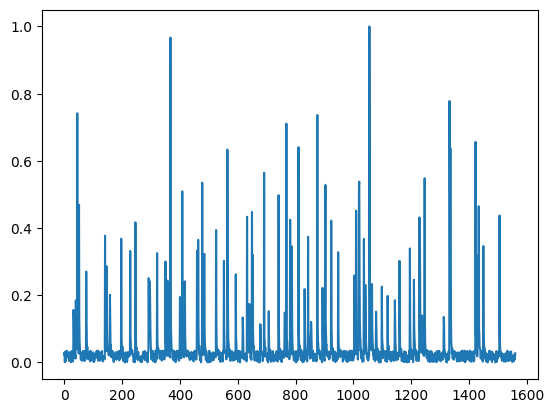

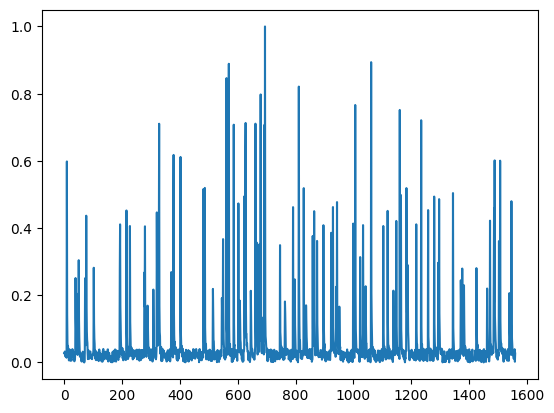

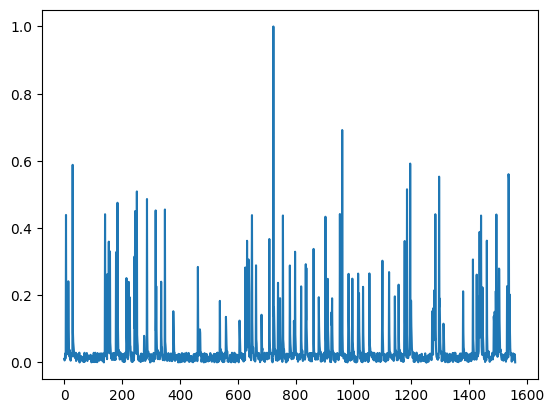

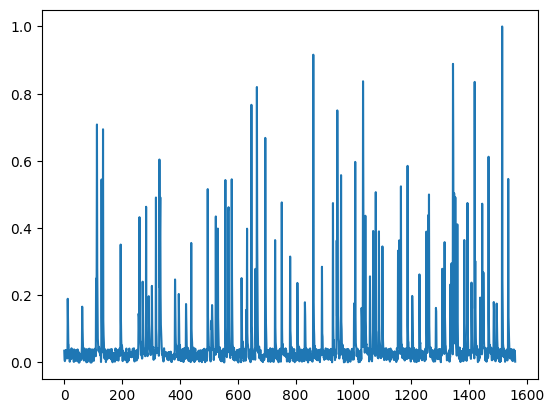

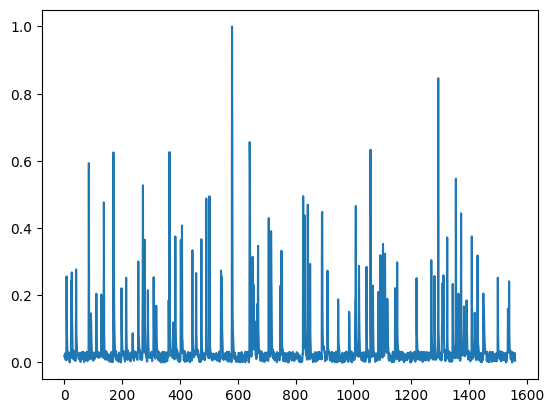

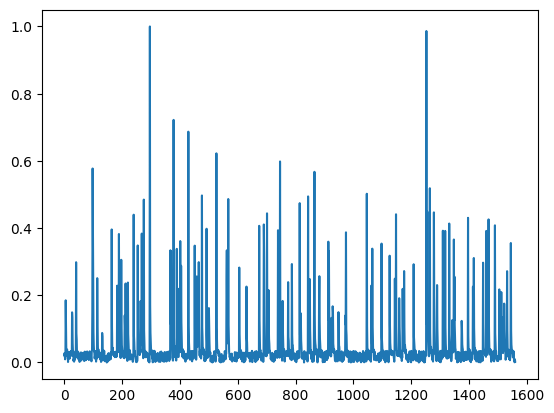

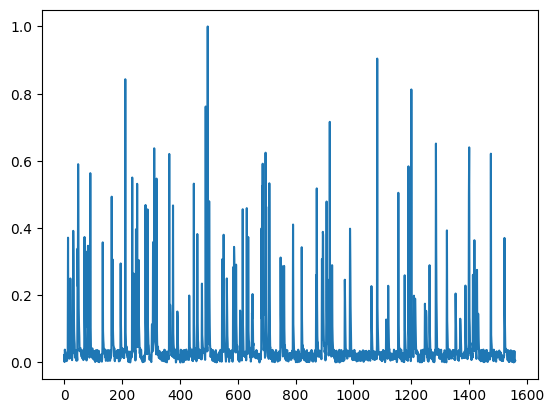

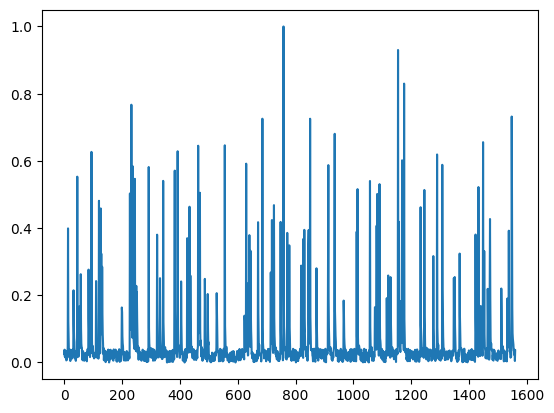

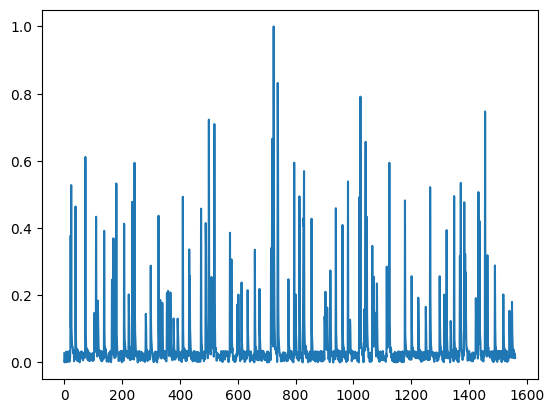

In [3]:
# Load the generated homemade TODs
with open('homemade_TOD.npy', 'rb') as file:
    mins = np.load(file)
    maxs = np.load(file)
    TODs_train = np.load(file)
    TODs_val = np.load(file)

# Check the loaded homemade TOD
print('Generated TODs have the shape: ', TODs_train.shape)
time_bins = TODs_train.shape[1]

for i in range(9):
    plt.plot(np.arange(time_bins), TODs_train[i*100,:,0])
    plt.show()

In [4]:
# Clean previous models
clear_session()

# Define the Generator model of GAN
def generator_model(time_bins, inputnoise_bins, hit_len):
    
    model = Sequential([
        Input(shape=inputnoise_bins),
        Dense(time_bins//12),
        Dropout(0.2),
        Reshape((time_bins//12, 1)),
        Conv1DTranspose(16, hit_len, padding='same', strides = 1, data_format='channels_last'),
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.2),
        Conv1DTranspose(8, hit_len//2, padding='same', strides = 2, data_format='channels_last'),
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.2),
        Conv1DTranspose(4, hit_len//4, padding='same', strides = 2, data_format='channels_last'),
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.2),
        Conv1DTranspose(1, hit_len//4, activation='tanh', padding='same', strides = 3, data_format='channels_last'),],
        name='Generator')
    
    return model

gen_show = generator_model(time_bins, 100, hit_len)
gen_show.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 130)               13130     
                                                                 
 dropout (Dropout)           (None, 130)               0         
                                                                 
 reshape (Reshape)           (None, 130, 1)            0         
                                                                 
 conv1d_transpose (Conv1DTr  (None, 130, 16)           192       
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 130, 16)           64        
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 130, 16)           0 

2023-09-11 14:10:32.716098: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
# Define the discriminator model of GAN with swish activation function
def discriminator_model(time_bins):
    
    model = Sequential([
        Input(shape=(time_bins, 1)),
        Conv1D(8, hit_len//4, activation='swish', padding='same', strides = 1, data_format='channels_last'),
        #MaxPooling1D(2),
        BatchNormalization(),
        Dropout(0.2),
        Conv1D(16, hit_len//2, activation='swish', padding='same', strides = 1, data_format='channels_last'),
        #MaxPooling1D(hit_len//3),
        BatchNormalization(),
        Dropout(0.2),
        Conv1D(32, hit_len, activation='swish', padding='same', strides = 2, data_format='channels_last'),
        #MaxPooling1D(hit_len//2),
        BatchNormalization(),
        Dropout(0.2),
        Flatten(),
        Dense(1, activation='sigmoid')],
        name='Discriminator_1')
    
    '''model.add(Dense(56, activation="relu"))
    model.add(Dense(28, activation="relu"))
    model.add(Dense(14, activation="relu"))
    model.add(Dense(7, activation="relu"))'''
    
    return model

discr_show = discriminator_model(time_bins)
discr_show.summary()

# Define the discriminator model of GAN with leakyrelu activation function
def discriminator_model_relu(time_bins):
    
    model = Sequential([
        Input(shape=(time_bins, 1)),
        Conv1D(32, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.2),
        Conv1D(16, hit_len//2, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.2),
        Conv1D(8, hit_len//4, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.2),
        Flatten(),
        Dense(1, activation='sigmoid')],
        name='Discriminator_2')

    
    return model

discr_show_relu = discriminator_model_relu(time_bins)
discr_show_relu.summary()

# Define the critic model of WGAN
def critic_model(time_bins):
    
    model = Sequential([
        Input(shape=(time_bins, 1)),
        Conv1D(32, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.2),
        Conv1D(16, hit_len//2, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.2),
        Conv1D(8, hit_len//4, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.2),
        Flatten(),
        Dense(1, activation='linear')],
        name='Critic')

    
    return model

critic_show = critic_model(time_bins)
critic_show.summary()

Model: "Discriminator_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1560, 8)           24        
                                                                 
 batch_normalization_3 (Bat  (None, 1560, 8)           32        
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 1560, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1560, 16)          656       
                                                                 
 batch_normalization_4 (Bat  (None, 1560, 16)          64        
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 1560, 16)      

In [6]:
# Define the GAN used only to train the generator
def mini_gan_model(generator, discriminator):
    
    discriminator.trainable = False
    
    model = Sequential(name='Mini_GAN')
    
    model.add(generator)
    model.add(discriminator)
    
    return model

mini_gan_show = mini_gan_model(gen_show, discr_show)
mini_gan_show.build((None, 100))
mini_gan_show.summary()

Model: "Mini_GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 1560, 1)           14159     
                                                                 
 Discriminator_1 (Sequentia  (None, 1)                 31529     
 l)                                                              
                                                                 
Total params: 45688 (178.47 KB)
Trainable params: 14103 (55.09 KB)
Non-trainable params: 31585 (123.38 KB)
_________________________________________________________________


In [7]:
# GAN class wrapping generator-discriminator couple
class GAN_self(Model):
    
    def __init__(self, generator, discriminator, time_bins, inputnoise_bins):
        
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.time_bins = time_bins
        self.inputnoise_bins = inputnoise_bins
        
    def compile(self, gen_optimizer, discr_optimizer, gen_loss, discr_loss, extra_discr):
        super(GAN, self).compile()
        self.gen_optimizer = gen_optimizer
        self.discr_optimizer = discr_optimizer
        self.gen_loss = gen_loss
        self.discr_loss = discr_loss
        self.extra_discr = extra_discr
    
    def train(self, real_TODs, epochs, batch_size=10, verbose=True):
        
        inputnoise = np.random.rand(batch_size, self.inputnoise_bins)

        with GradientTape() as gen_tape, GradientTape() as disc_tape:
            
            synth_TODs = self.generator(inputnoise, training=True)
            
            real_preds = self.discriminator(real_TODs, training=True)
            synth_preds = self.discriminator(synth_TODs, training=True)

            gen_loss = self.gen_loss(synth_preds)
            discr_loss = self.discr_loss(real_preds, synth_preds)
      

        gen_grad = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        discr_grad = disc_tape.gradient(discr_loss, self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(gen_grad, self.generator.trainable_variables))
        self.discr_optimizer.apply_gradients(zip(discr_grad, self.discriminator.trainable_variables))
        

        
        history = {"gen_loss": np.zeros(epochs), "discr_loss": np.zeros(epochs)}
        
        for epoch in range(epochs):
            
            start = time.time()

            for i in range(real_TODs.shape[0]//batch_size):
                
                batch_step = i*batch_size
                tods_batch = real_TODs[batch_step:batch_step+batch_size]
                gen_loss, discr_loss = self.train_step(tods_batch)
                
            history["gen_loss"][epoch] = gen_loss
            history["discr_loss"][epoch] = discr_loss
            
            if verbose:
                print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
        return history

In [8]:
# GAN class wrapping generator-discriminator couple
class GAN(Model):
    
    def __init__(self, generator, discriminator, time_bins, inputnoise_bins):
        
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.time_bins = time_bins
        self.inputnoise_bins = inputnoise_bins
        
    def compile(self, gen_optimizer, discr_optimizer, gen_loss, discr_loss, extra_discr):
        
        super().compile()
        self.gen_optimizer = gen_optimizer
        self.discr_optimizer = discr_optimizer
        self.gen_loss = gen_loss
        self.discr_loss = discr_loss
        self.extra_discr = extra_discr
        
        '''self.add_metric(Mean(), name="gen_loss")
        self.add_metric(Mean(), name="discr_real_loss")
        self.add_metric(Mean(), name="discr_fake_loss")
        self.add_metric(BinaryAccuracy(), name="gen_acc")
        self.add_metric(BinaryAccuracy(), name="discr_real_acc")
        self.add_metric(BinaryAccuracy(), name="discr_fake_acc")'''
        
        self.gen_loss_tracker = Mean(name="gen_loss")
        self.discr_real_loss_tracker = Mean(name="discr_real_loss")
        self.discr_fake_loss_tracker = Mean(name="discr_fake_loss")
        self.gen_acc_tracker = BinaryAccuracy(name="gen_acc")
        self.discr_real_acc_tracker = BinaryAccuracy(name="discr_real_acc")
        self.discr_fake_acc_tracker = BinaryAccuracy(name="discr_fake_acc")
        
    @property
    def metrics(self):
        
        return [self.gen_loss_tracker, self.discr_real_loss_tracker, self.discr_fake_loss_tracker,
                self.gen_acc_tracker, self.discr_real_acc_tracker, self.discr_fake_acc_tracker]
        
    def train_step(self, real_data):
        
        batch_size = real_data.shape[0]
        inputnoise = np.random.normal(size=(batch_size, self.inputnoise_bins))
                
        # Train the discriminator
        for i in range(extra_discr+1):
            
            with GradientTape() as disc_real_tape, GradientTape() as disc_fake_tape:

                fake_data = self.generator(inputnoise, training=False)
                real_preds = self.discriminator(real_data, training=True)
                fake_preds = self.discriminator(fake_data, training=True)

                discr_real_loss, discr_fake_loss = self.discr_loss(real_preds, fake_preds)

            discr_real_grad = disc_real_tape.gradient(discr_real_loss, self.discriminator.trainable_variables)      
            self.discr_optimizer.apply_gradients(zip(discr_real_grad, self.discriminator.trainable_variables))

            discr_fake_grad = disc_fake_tape.gradient(discr_fake_loss, self.discriminator.trainable_variables)      
            self.discr_optimizer.apply_gradients(zip(discr_fake_grad, self.discriminator.trainable_variables))
        
        # Train the generator
        with GradientTape() as gen_tape:
            
            synth_TODs = self.generator(inputnoise, training=True)
            synth_preds = self.discriminator(synth_TODs, training=False)

            gen_loss = self.gen_loss(synth_preds)

        gen_grad = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grad, self.generator.trainable_variables))
        
        for m in self.metrics:
            if m.name == 'gen_loss':
                m.update_state(gen_loss)
            if m.name == 'discr_real_loss':
                m.update_state(discr_real_loss)
            if m.name == 'discr_fake_loss':
                m.update_state(discr_fake_loss)
            if m.name == 'gen_acc':
                m.update_state(np.ones(batch_size), synth_preds)
            if m.name == 'discr_real_acc':
                m.update_state(np.ones(batch_size), real_preds)
            if m.name == 'discr_fake_acc':
                m.update_state(np.zeros(batch_size), fake_preds)
        
        '''self.gen_loss_tracker.update_state(gen_loss)
        self.discr_real_loss_tracker.update_state(discr_real_loss)
        self.discr_fake_loss_tracker.update_state(discr_fake_loss)
        
        self.gen_acc_tracker.update_state(np.ones(batch_size), synth_preds)
        self.discr_real_acc_tracker.update_state(np.ones(batch_size), real_preds)
        self.discr_fake_acc_tracker.update_state(np.zeros(batch_size), fake_preds)'''
        
        return {m.name: m.result() for m in self.metrics}
    
        '''"gen_loss": self.gen_loss_tracker.result(), "discr_real_loss": self.discr_real_loss_tracker.result(),
        "discr_fake_loss": self.discr_fake_loss_tracker.result(),'''

In [9]:
# WGAN class wrapping generator-critic couple
class WGAN(Model):
    
    def __init__(self, generator, critic, time_bins, inputnoise_bins):
        
        super().__init__()
        self.generator = generator
        self.critic = critic
        self.time_bins = time_bins
        self.inputnoise_bins = inputnoise_bins
        
    def compile(self, gen_optimizer, critic_optimizer, gen_loss, critic_loss, extra_critic):
        
        super().compile()
        self.gen_optimizer = gen_optimizer
        self.critic_optimizer = critic_optimizer
        self.gen_loss = gen_loss
        self.critic_loss = critic_loss
        self.gen_loss_tracker = Mean(name="gen_loss")
        self.critic_loss_tracker = Mean(name="critic_loss")
        self.extra_critic = extra_critic
    
    def train_step(self, real_data):
        
        batch_size = real_data.shape[0]
        inputnoise = np.random.normal(size=(batch_size, self.inputnoise_bins))
        
        # Train the critic
        for i in range(self.extra_critic+1):
            
            with GradientTape() as critic_tape:

                fake_TODs = self.generator(inputnoise, training=False)
                real_preds = self.critic(real_data, training=True)
                fake_preds = self.critic(fake_TODs, training=True)

                critic_loss = self.critic_loss(real_preds, fake_preds)

            critic_grad = critic_tape.gradient(critic_loss, self.critic.trainable_variables)      
            self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))

            for w in self.critic.trainable_variables:
                
                w.assign(clip_by_value(w, -1., 1.))
        
        # Train the generator
        with GradientTape() as gen_tape:
            
            synth_TODs = self.generator(inputnoise, training=True)
            synth_preds = self.critic(synth_TODs, training=False)
    
            gen_loss = self.gen_loss(synth_preds)

        gen_grad = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grad, self.generator.trainable_variables))
        
        for w in self.generator.trainable_variables:
                
                w.assign(clip_by_value(w, -1., 1.))
        
        self.gen_loss_tracker.update_state(gen_loss)
        self.critic_loss_tracker.update_state(critic_loss)
        
        return {"gen_loss": self.gen_loss_tracker.result(), "critic_loss": self.critic_loss_tracker.result()}

In [ ]:
# Definition of loss functions with binary cross entropy between the NNs predictions and correct labels
cross_entropy = BinaryCrossentropy(from_logits=False)

def gen_loss(synth_preds):
    
    return cross_entropy(np.ones(synth_preds.shape), synth_preds)

def discr_loss(real_preds, synth_preds):
    
    real_loss = cross_entropy(np.ones(real_preds.shape), real_preds)
    synth_loss = cross_entropy(np.zeros(synth_preds.shape), synth_preds)
    
    return real_loss, synth_loss

In [ ]:
# Clean previous models
clear_session()

# Set the optimizers and train parameters
inputnoise_bins = 100
batch_size = 10
epochs = 100
lr = 0.05
momentum = 0.1
gen_optimizer = SGD(learning_rate=lr, momentum=momentum)
discr_optimizer = SGD(learning_rate=lr, momentum=momentum)
#gen_optimizer = Nadam(learning_rate=lr)
#discr_optimizer = Nadam(learning_rate=lr)
extra_discr = 0

# Build the GAN and train it
gen = generator_model(time_bins, inputnoise_bins, hit_len)
discr = discriminator_model_relu(time_bins)
#mini_gan = mini_gan_model(gen, discr)
gen.summary()
discr.summary()

gan_toy = GAN(gen, discr, time_bins, inputnoise_bins)
gan_toy.compile(gen_optimizer, discr_optimizer, gen_loss, discr_loss, extra_discr)

In [ ]:
# Train and validate the GAN
history = gan_toy.fit(TODs_train, batch_size=batch_size, epochs=epochs)

In [ ]:
# Plot the training losses along the epochs
plt.plot(history.history["gen_loss"], label="Generator")
plt.plot(history.history["discr_real_loss"], label="Discriminator on real")
plt.plot(history.history["discr_fake_loss"], label="Discriminator on fake")
plt.title("Loss functions")
plt.legend()
plt.show()

'''# Plot the training accuracy along the epochs
plt.plot(history.history["real_acc"], label="Discriminator on real")
plt.plot(history.history["fake_acc"], label="Discriminator on fake")
plt.title("Discriminator accuracy")
plt.legend()
plt.show()'''

In [ ]:
# Plot some synthetic TOD after the training
test_inputnoise = np.random.normal(size=(5, inputnoise_bins))
test_synth_TODs = gan_toy.generator(test_inputnoise)

for i in range(5):
    plt.plot(np.arange(time_bins), test_synth_TODs[i,:,0])
    plt.show()
    
# TEst the Discriminator response for synthetic TOD
test_response = gan_toy.discriminator(test_synth_TODs)
print(test_response)
test_response1 = gan_toy.discriminator(TODs_train[:5])
print(test_response1)

In [ ]:
# Definition of loss functions for the Wasserstein GAN (with NN output not limited to 0,1)

def w_gen_loss(synth_preds):
    
    return - reduce_mean(synth_preds)

def w_critic_loss(real_preds, synth_preds):
    
    real_loss = reduce_mean(real_preds)
    synth_loss = reduce_mean(synth_preds)
    
    return - (real_loss - synth_loss)

In [ ]:
# Clean previous models
clear_session()

# Set the optimizers and train parameters
inputnoise_bins = 100
batch_size = 10
epochs = 50
lr = 0.1
gen_optimizer = SGD(learning_rate=lr, momentum=momentum)
discr_optimizer = SGD(learning_rate=lr, momentum=momentum)
#gen_optimizer = Nadam(learning_rate=lr)
#discr_optimizer = Nadam(learning_rate=lr)
extra_critic = 0

# Build the GAN and train it
gen = generator_model(time_bins, inputnoise_bins, hit_len)
critic = critic_model(time_bins)
#mini_gan = mini_gan_model(gen, critic)
gen.summary()
critic.summary()

wgan = WGAN(gen, critic, mini_gan, time_bins, inputnoise_bins)
wgan.compile(gen_optimizer, critic_optimizer, w_gen_loss, w_critic_loss, extra_critic)

In [ ]:
# Train and validate the WGAN
history = wgan.fit(TODs_train, batch_size=batch_size, epochs=epochs)

In [ ]:
# Plot the training losses along the epochs
plt.plot(history.history["gen_loss"], label="Generator")
plt.plot(history.history["critic_loss"], label="Critic")
plt.title("Loss functions")
plt.legend()
plt.show()

'''# Plot the training accuracy along the epochs
plt.plot(history.history["real_acc"], label="Discriminator on real")
plt.plot(history.history["fake_acc"], label="Discriminator on fake")
plt.title("Discriminator accuracy")
plt.legend()
plt.show()'''

In [ ]:
# Plot some synthetic TOD after the training
test_inputnoise = np.random.normal(size=(TODs_train.shape[0], inputnoise_bins))
test_synth_TODs = wgan.generator(test_inputnoise)

for i in range(5):
    plt.plot(np.arange(time_bins), test_synth_TODs[i*TODs_train.shape[0]//5,:,0])
    plt.show()
    
# TEst the Discriminator response for synthetic TOD
test_response_synth = wgan.critic(test_synth_TODs)
test_response_real = wgan.critic(TODs_train)
plt.plot(test_response_synth, label="Synthetic")
plt.plot(test_response_real, label="Real")
plt.title("Critic response")
plt.legend()
plt.show()

In [68]:
# Clean previous models
clear_session()

# Define simplest Generator and discriminator models of GAN
def simple_generator_model(time_bins, inputnoise_bins, hit_len):
    
    model = Sequential([
        Input(shape=inputnoise_bins),
        Dense(time_bins//12),
        Reshape((time_bins//12, 1)),
        Conv1DTranspose(12, hit_len, padding='same', strides = 1, data_format='channels_last'),
        BatchNormalization(),
        LeakyReLU(),
        Conv1DTranspose(6, hit_len, padding='same', strides = 2, data_format='channels_last'),
        BatchNormalization(),
        LeakyReLU(),
        Conv1DTranspose(1, hit_len, padding='same', strides = 6, data_format='channels_last')],
        name='Generator')
    
    return model

def simple_discriminator_model(time_bins):
    
    model = Sequential([
        Input(shape=(time_bins, 1)),
        Conv1D(16, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1D(16, hit_len, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1D(8, hit_len, padding='same', strides = hit_len, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Flatten(),
        Dense(1, activation='sigmoid')],
        name='Discriminator')
    
    return model

def simple_critic_model_relu(time_bins):
    
    model = Sequential([
        Input(shape=(time_bins, 1)),
        Conv1D(10, hit_len, padding='same', strides = 1, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1D(10, hit_len, padding='same', strides = hit_len, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1D(10, hit_len//2, padding='same', strides = 2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Conv1D(10, hit_len//2, padding='same', strides = hit_len//2, data_format='channels_last'),
        LeakyReLU(),
        BatchNormalization(),
        Flatten(),
        Dense(1, activation='linear')],
        name='Critic')

    
    return model

def simple_critic_model_smooth(time_bins):
    
    model = Sequential([
        Input(shape=(time_bins, 1)),
        Conv1D(10, hit_len//2, padding='same', strides = 1, data_format='channels_last', activation='tanh'),
        BatchNormalization(),
        Conv1D(10, hit_len, padding='same', strides = 1, data_format='channels_last', activation='tanh'),
        BatchNormalization(),
        Conv1D(10, hit_len//2, padding='same', strides = 2, data_format='channels_last', activation='tanh'),
        BatchNormalization(),
        Conv1D(10, hit_len, padding='same', strides = hit_len//2, data_format='channels_last', activation='tanh'),
        BatchNormalization(),
        Flatten(),
        Dense(1, activation='linear')],
        name='Critic')

    
    return model

# Define a test empty generator
def empty_generator_model(time_bins, inputnoise_bins, hit_len):
    
    model = Sequential([
        Input(shape=inputnoise_bins),
        Dense(time_bins//12, trainable=False),
        Reshape((time_bins//12, 1)),
        Conv1DTranspose(1, 12, padding='same', strides = 12, data_format='channels_last', trainable=False)],
        name='Empty_generator')
    
    return model

# Definition of loss functions with binary cross entropy between the NNs predictions and correct labels for
# both GAN and WGAN
model_struct = 'GAN'

if model_struct == 'GAN':
    
    cross_entropy = BinaryCrossentropy(from_logits=False)

    def gen_loss(synth_preds):

        return cross_entropy(np.ones(synth_preds.shape), synth_preds)

    def discr_loss(real_preds, synth_preds):

        real_loss = cross_entropy(np.ones(real_preds.shape), real_preds)
        synth_loss = cross_entropy(np.zeros(synth_preds.shape), synth_preds)

        return real_loss, synth_loss

if model_struct == 'WGAN':

    def gen_loss(synth_preds):

        return - reduce_mean(synth_preds)

    def discr_loss(real_preds, synth_preds):

        real_loss = reduce_mean(real_preds)
        synth_loss = reduce_mean(synth_preds)

        return synth_loss - real_loss

In [73]:
# Clean previous models
clear_session()

# Random seeds initialization
tf.random.set_seed(42)
np.random.seed(24)

# Set the optimizers and train parameters
inputnoise_bins = 100
batch_size = 20
epochs = 50
lr = 1e-4
momentum = 0.5
gen_optimizer = SGD(learning_rate=lr, momentum=momentum)
discr_optimizer = SGD(learning_rate=lr, momentum=momentum)
#gen_optimizer = Nadam(learning_rate=lr)
#discr_optimizer = Nadam(learning_rate=lr)
extra_discr = 4

# Build the GAN and train it
model_name = 'simple_gan_1'
! mkdir {model_name}
gen = simple_generator_model(time_bins, inputnoise_bins, hit_len)
discr = simple_discriminator_model(time_bins)
#mini_gan = mini_gan_model(gen, discr)
gen.summary()
discr.summary()

with open(model_name + '/model_summary.txt', 'w') as f:
    gen.summary(print_fn=lambda x: f.write(x + '\n'))
    discr.summary(print_fn=lambda x: f.write(x + '\n'))

gan_toy = GAN(gen, discr, time_bins, inputnoise_bins)
gan_toy.compile(gen_optimizer, discr_optimizer, gen_loss, discr_loss, extra_discr)

mkdir: cannot create directory 'simple_gan_1': File exists
Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 130)               13130     
                                                                 
 reshape (Reshape)           (None, 130, 1)            0         
                                                                 
 conv1d_transpose (Conv1DTr  (None, 130, 12)           144       
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 130, 12)           48        
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 130, 12)           0         
                                                                

In [74]:
# Train and validate the GAN
history = gan_toy.fit(TODs_train, batch_size=batch_size, epochs=epochs)

Epoch 1/50
45/45 [==============================] - 9s 74ms/step - gen_loss: 1.2597 - discr_real_loss: 0.8692 - discr_fake_loss: 0.2412 - gen_acc: 0.0322 - discr_real_acc: 0.5167 - discr_fake_acc: 0.9600
Epoch 2/50
45/45 [==============================] - 3s 74ms/step - gen_loss: 3.3550 - discr_real_loss: 0.8103 - discr_fake_loss: 0.1532 - gen_acc: 0.0000e+00 - discr_real_acc: 0.5322 - discr_fake_acc: 1.0000
Epoch 3/50
45/45 [==============================] - 3s 75ms/step - gen_loss: 1.9586 - discr_real_loss: 0.7707 - discr_fake_loss: 0.2453 - gen_acc: 0.2144 - discr_real_acc: 0.5589 - discr_fake_acc: 1.0000
Epoch 4/50
45/45 [==============================] - 3s 74ms/step - gen_loss: 1.1017 - discr_real_loss: 0.7401 - discr_fake_loss: 0.2466 - gen_acc: 0.5189 - discr_real_acc: 0.5722 - discr_fake_acc: 1.0000
Epoch 5/50
45/45 [==============================] - 3s 75ms/step - gen_loss: 1.0052 - discr_real_loss: 0.7128 - discr_fake_loss: 0.2411 - gen_acc: 0.4122 - discr_real_acc: 0.5867 -

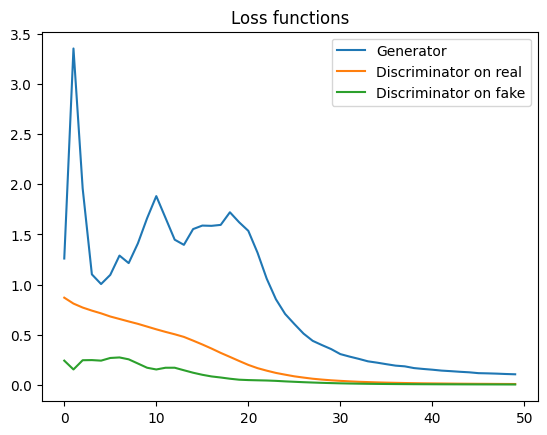

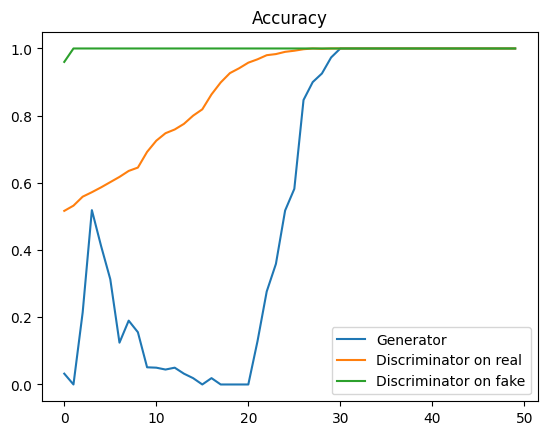

In [75]:
# Plot the training losses along the epochs
plt.plot(history.history["gen_loss"], label="Generator")
plt.plot(history.history["discr_real_loss"], label="Discriminator on real")
plt.plot(history.history["discr_fake_loss"], label="Discriminator on fake")
#plt.plot(history.history["critic_loss"], label="Critic")
plt.title("Loss functions")
plt.legend()
plt.savefig(model_name + '/loss.pdf')
plt.show()

# Plot the accuracy along the epochs
plt.plot(history.history["gen_acc"], label="Generator")
plt.plot(history.history["discr_real_acc"], label="Discriminator on real")
plt.plot(history.history["discr_fake_acc"], label="Discriminator on fake")
plt.title("Accuracy")
plt.legend()
plt.savefig(model_name + '/acc.pdf')
plt.show()

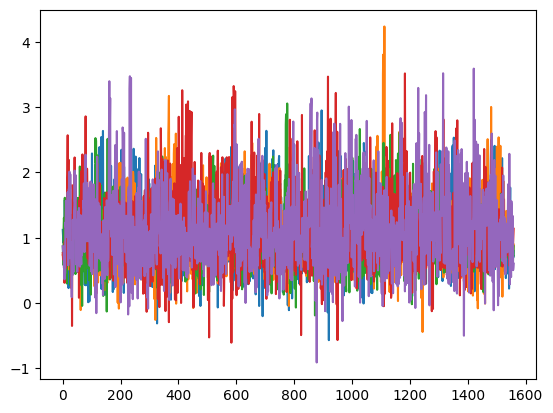

4/4 [==============================] - 0s 3ms/step


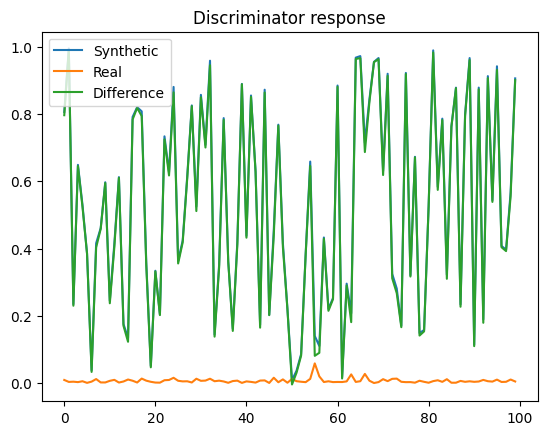

tf.Tensor(0.0072550587, shape=(), dtype=float32)
tf.Tensor(0.5211944, shape=(), dtype=float32)
tf.Tensor(0.5139393, shape=(), dtype=float32)


In [76]:
# Plot some synthetic TOD after the training
test_inputnoise = np.random.normal(size=(TODs_val.shape[0], inputnoise_bins))
test_synth_TODs = gan_toy.generator(test_inputnoise)

for i in range(5):
    plt.plot(np.arange(time_bins), test_synth_TODs[i*TODs_val.shape[0]//5,:,0])
plt.savefig(model_name + '/synth_TOD_exemple.pdf')
plt.show()

# TEst the Discriminator response for synthetic TOD
#test_response_synth = gan_toy.discriminator(test_synth_TODs)
#test_response_real = gan_toy.discriminator(TODs_train)
test_response_synth = gan_toy.discriminator.predict(test_synth_TODs)
test_response_real = gan_toy.discriminator.predict(TODs_val)
plt.plot(test_response_synth, label="Synthetic")
plt.plot(test_response_real, label="Real")
plt.plot(test_response_synth - test_response_real, label="Difference")
plt.title("Discriminator response")
plt.legend()

plt.savefig(model_name + '/response_test.pdf')
plt.show()

print(reduce_mean(test_response_real))
print(reduce_mean(test_response_synth))
print(reduce_mean(test_response_synth) - reduce_mean(test_response_real))

In [ ]:
# Clean previous models
clear_session()

# Train and validate the GAN
epochs = 10
discr_toy = simple_discriminator_model_relu(time_bins)

fake = denormalize(TODs_train, mins, maxs)
labels = np.append(np.ones(TODs_train.shape[0]),np.zeros(TODs_train.shape[0]))
tods = np.append(TODs_train, fake, axis=0)

shuffle_ind = np.random.permutation(tods.shape[0])
tods = tods[shuffle_ind]
labels = labels[shuffle_ind]

discr_toy.compile(optimizer=Nadam, loss='binary_crossentropy', metrics='accuracy')
history = discr_toy.fit(tods, labels, batch_size=batch_size, epochs=epochs)

In [ ]:
test_response = discr_toy(tods[:10])
print(test_response, labels[:10])